# Moran Process on Different Graphs

In [21]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Set the style for nicer plots
sns.set_theme(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Checking that indeed the graphs were created and added to the database

In [24]:
filename = 'runs_database.csv'
graph_csv = 'graph_database.csv'
data_dir = 'simulation_data'

graph_df = pd.read_csv(os.path.join(data_dir, graph_csv))
graph_df

,wl_hash,name,graph_type,n_nodes,n_edges,is_directed,density,is_connected,graph6_string,avg_degree,...,max_degree_centrality,avg_betweenness_centrality,max_betweenness_centrality,avg_closeness_centrality,max_closeness_centrality,branching,depth,n_rods,rods_length,rod_length
0,4e5dcddc1efcdbabd7dded32c7017f62,complete_n31,Complete,31,465,False,1.000000,True,^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~...,30.000000,...,1.000000,0.000000,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
1,8930697f2d93d4b53c61cfcce1af3ad2,mammalian_b2_d4,Mammalian,31,30,False,0.064516,True,^qO`?_OA?O?_@??_?O?A??O??_?@???_??O??A???O???_...,1.935484,...,0.100000,0.136374,0.627586,0.208785,0.306122,2.0,4.0,NaN,NaN,NaN
2,9c3de7e9fb2b11fbfca795d2a51c85f0,avian_r4_l7,Avian,31,34,False,0.073118,True,^[CGGC@OK??@?@??_?G?@O?E?????G??C??@???G???g??...,2.193548,...,0.166667,0.117390,0.498851,0.233827,0.329670,NaN,NaN,4.0,7.0,NaN
3,6ce340cfc8a2dcdf4b8a7f7d78f74059,fish_r3_l3,Fish,30,29,False,0.066667,True,]iOGOO@?S??@?@?@??_?@??G??_??G??G?G????G???_??...,1.933333,...,0.137931,0.141954,0.689655,0.208357,0.315217,NaN,NaN,3.0,NaN,3.0


In [26]:

# Replace 'your_results.csv' with your actual filename
df = pd.read_csv(os.path.join(data_dir, filename))

# df = df[~df['graph_name'].str.contains("cycle", case=False, na=False)]

# Display basic info to verify
print(f"Loaded {len(df)} rows.")
display(df.head())

Loaded 4000 rows.


,wl_hash,graph_name,r,fixation,steps,initial_mutants,selection_coeff,duration
0,4e5dcddc1efcdbabd7dded32c7017f62,complete_n31,1.0,False,5,1,1.0,0.000330
1,4e5dcddc1efcdbabd7dded32c7017f62,complete_n31,1.0,False,27,1,1.0,0.000756
2,4e5dcddc1efcdbabd7dded32c7017f62,complete_n31,1.0,False,37,1,1.0,0.001162
3,4e5dcddc1efcdbabd7dded32c7017f62,complete_n31,1.0,False,3,1,1.0,0.000193
4,4e5dcddc1efcdbabd7dded32c7017f62,complete_n31,1.0,False,10,1,1.0,0.000560


In [27]:
# Get list of unique graph names
unique_graphs = df['wl_hash'].unique()


for graph_hash in unique_graphs:
    unique_r_values = df_enriched[df_enriched['wl_hash'] == graph_hash]['r'].unique()
    N = graph_df[graph_df['wl_hash'] == graph_hash]['n_nodes']
    # N = subset['n_nodes'].iloc[0]
    graph_name = graph_df[graph_df['wl_hash'] == graph_hash]['graph_name']
    for r in unique_r_values:
        # 1. Filter data for this specific graph
        subset = df_enriched[(df_enriched['wl_hash'] == graph_hash) & (df_enriched['r'] == r)]
        # 2. Filter for only successful fixations
        fixation_subset = subset[subset['fixation'] == True]
        
        # 3. Calculate Probability of Fixation
        p_fix = subset['fixation'].mean()
        n_runs = len(subset)
        n_success = len(fixation_subset)
        
        # --- PLOTTING ---
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Main Title with Statistics
        fig.suptitle(f"Graph: {graph_name}|N: {N} |r: {r} | Runs: {n_runs} | P(fix): {p_fix:.3f} ({n_success}/{n_runs})", 
                    fontsize=14, fontweight='bold', y=1.05)
        
        # Plot 1: Histogram of Steps (All runs: Fixation + Extinction)
        sns.histplot(data=subset, x='steps', hue='fixation', multiple="stack", 
                    ax=axes[0], palette={True: 'green', False: 'gray'})
        median_steps = subset['steps'].median()
        axes[0].set_title(f"Distribution of Steps (All Runs) — median: {median_steps:.0f} steps")
        axes[0].set_xlabel("Steps")
        axes[0].set_ylabel("Frequency")
        
        # Plot 2: Histogram of Steps (Only Fixation=True)
        if not fixation_subset.empty:
            sns.histplot(data=fixation_subset, x='steps', ax=axes[1], color='green', kde=True)
            median_steps_fixed = fixation_subset['steps'].median()
            axes[1].set_title(f"Distribution of Steps (Only Fixation Events) — median: {median_steps_fixed:.0f} steps")
            axes[1].set_xlabel("Steps to Fixation")
            axes[1].set_ylabel("Frequency")
        else:
            # Handle case where no fixations occurred
            axes[1].text(0.5, 0.5, "No Fixation Events Observed", 
                        horizontalalignment='center', verticalalignment='center', fontsize=12)
            axes[1].set_title("Distribution of Steps (Only Fixation Events)")

        plt.tight_layout()
        plt.show()

NameError: name 'df_enriched' is not defined

In [ ]:
# ---------------------------------------------------------
# TABLE 1: Median Steps (Only Successful Fixations)
# ---------------------------------------------------------
fixation_df = df[df['fixation'] == True]

table_med_fixation = fixation_df.pivot_table(
    index=['graph_name', 'N'],  # Group by Name AND N
    columns='r', 
    values='steps', 
    aggfunc='median'
)

# Sort by Row Average:
# 1. Calculate mean across columns (axis=1)
# 2. Sort the DataFrame by that mean
# 3. Drop the temporary mean column so it doesn't show in the final table
table_med_fixation = table_med_fixation.assign(row_mean=table_med_fixation.mean(axis=1)) \
                               .sort_values('row_mean') \
                               .drop(columns='row_mean')

print("--- Table 1: Median Steps (Only Successful Fixations) [Sorted by Row Avg] ---")
display(table_med_fixation)

# ---------------------------------------------------------
# TABLE 2: Median Steps (All Runs)
# ---------------------------------------------------------
table_med_steps_absorption = df.pivot_table(
    index=['graph_name', 'N'], 
    columns='r', 
    values='steps', 
    aggfunc='median'
)

# Sort by Row Average
table_med_steps_absorption = table_med_steps_absorption.assign(row_mean=table_med_steps_absorption.mean(axis=1)) \
                     .sort_values('row_mean') \
                     .drop(columns='row_mean')

print("\n--- Table 2: Median Steps (All Runs) [Sorted by Row Avg] ---")
display(table_med_steps_absorption)

--- Table 1: Median Steps (Only Successful Fixations) [Sorted by Row Avg] ---


,r,1.0,1.1
graph_name,N,,
complete_n31,31,933.0,655.5
avian_r5_l7,38,6016.0,4562.5
mammalian_b2_d4,31,8273.0,6855.0
fish_r5_l7,110,562447.0,120801.0



--- Table 2: Median Steps (All Runs) [Sorted by Row Avg] ---


,r,1.0,1.1
graph_name,N,,
complete_n31,31,32.0,35.0
avian_r5_l7,38,46.0,50.5
mammalian_b2_d4,31,55.0,63.0
fish_r5_l7,110,254.0,361.5


In [ ]:

# ---------------------------------------------------------
# TABLE 3: Fixation Probability (P_fix)
# ---------------------------------------------------------
table_prob = df.pivot_table(
    index=['graph_name', 'N'], 
    columns='r', 
    values='fixation', 
    aggfunc='mean'  # Mean of boolean = Probability
)

# Sort by Row Average (Descending: Highest probability at the top)
table_prob = table_prob.assign(row_mean=table_prob.mean(axis=1)) \
                       .sort_values('row_mean', ascending=False) \
                       .drop(columns='row_mean')

print("--- Table 3: Fixation Probability (P_fix) [Sorted by High -> Low] ---")
display(table_prob)

--- Table 3: Fixation Probability (P_fix) [Sorted by High -> Low] ---


,r,1.0,1.1
graph_name,N,,
complete_n31,31,0.030,0.116
mammalian_b2_d4,31,0.032,0.112
fish_r5_l7,110,0.006,0.130
avian_r5_l7,38,0.026,0.072


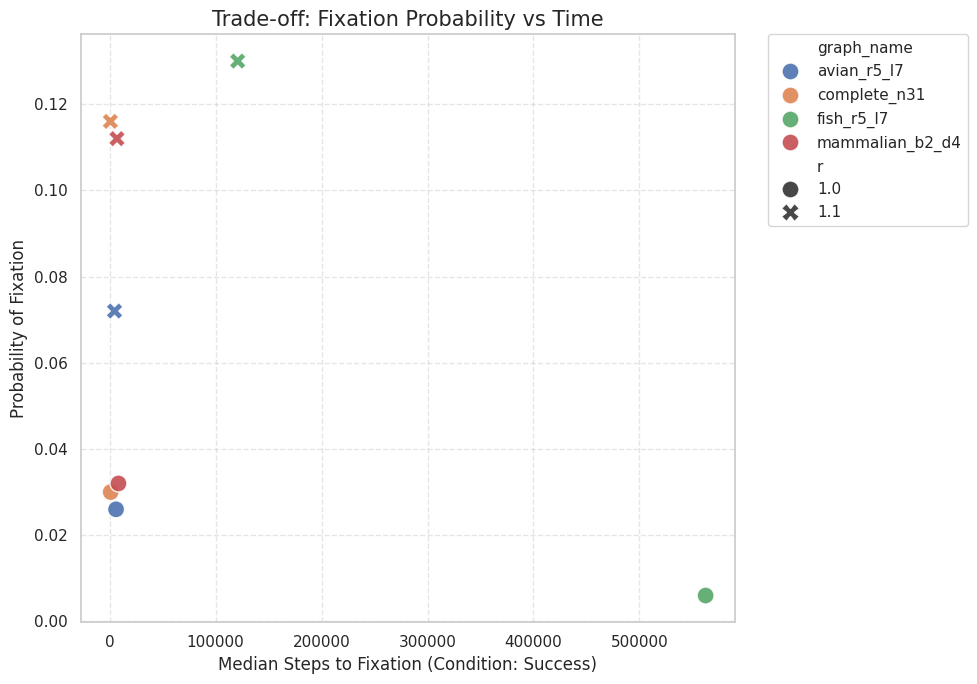

In [ ]:

# 2. Aggregation Logic
# We need to compute stats for each (Graph, r) pair independently

# Metric A: Fixation Probability (Using all data)
# Group by graph and r, then take mean of 'fixation' (True/False -> 1/0)
prob_df = df.groupby(['graph_name', 'r'])['fixation'].mean().reset_index(name='prob_fixation')

# Metric B: Median Steps (Using only SUCCESSFUL fixations)
# We filter first, because we don't want extinction times contaminating this metric
success_only_df = df[df['fixation'] == True]
time_df = success_only_df.groupby(['graph_name', 'r'])['steps'].median().reset_index(name='median_steps')

# Merge metrics into one plotting table
plot_data = pd.merge(prob_df, time_df, on=['graph_name', 'r'])

# 3. Create Scatter Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=plot_data,
    x='median_steps',
    y='prob_fixation',
    hue='graph_name',  # Different colors for different graphs
    style='r',         # Different shapes for different r values
    s=150,             # Make points larger
    palette='deep',    # Nice color palette
    alpha=0.9
)

# 4. Styling
plt.title('Trade-off: Fixation Probability vs Time', fontsize=15)
plt.xlabel('Median Steps to Fixation (Condition: Success)', fontsize=12)
plt.ylabel('Probability of Fixation', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Move legend outside to keep plot clean
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

# Probability for an Active Step
Here let's see if indeed the higher the multiplication of $N_{mut} \times N_{wt}$ there is a higher chance for an active step. 


Graph with WL hash aef3e7548667503e77f0d37ebf1047c1 already exists in database


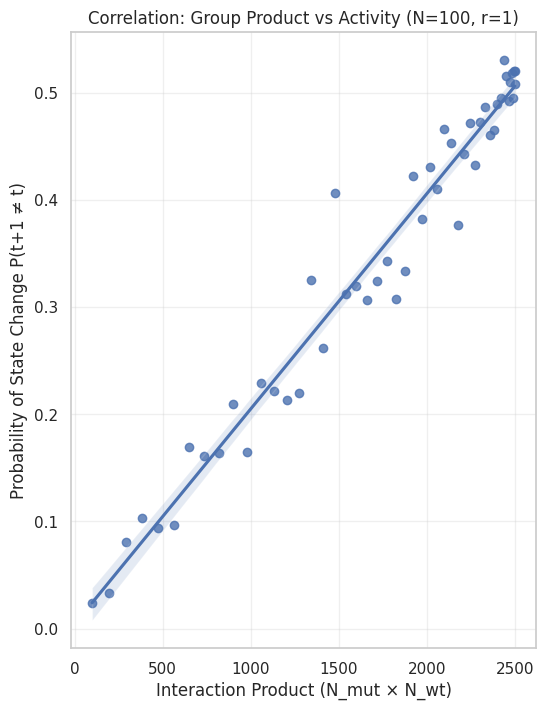

In [ ]:
from population_graph import PopulationGraph
from process_run import ProcessRun

N = 100
r=1
sim = ProcessRun(PopulationGraph.complete_graph(N=N), selection_coefficient=r)
sim.initialize_random_mutant(n_mutants=N//2)
result = sim.run(track_history=True)
            
history = result['history']
n_mutants = history[:-1]
n_wt = N - n_mutants
interaction_product = n_mutants * n_wt

is_active = (history[1:] != history[:-1]).astype(int)

interaction_df = pd.DataFrame({'interaction_product': interaction_product,
                               'is_active': is_active})

stats = interaction_df.groupby('interaction_product')['is_active'].mean().reset_index()
stats.columns = ['N_mutants x N_non_mutants', 'P(change)']

plt.figure(figsize=(6,8))
sns.regplot(data=stats, x=stats.columns[0], y=stats.columns[1])
plt.title(f'Correlation: Group Product vs Activity (N={N}, r={r})')
plt.ylabel('Probability of State Change P(t+1 ≠ t)')
plt.xlabel('Interaction Product (N_mut × N_wt)')
plt.grid(True, alpha=0.3)
plt.show()



# Gemini's Code here! 

In [ ]:
N = 100
sim = ProcessRun(PopulationGraph.complete_graph(N=N), selection_coefficient=1.2)

# 1. Run your simulation (assuming you have your classes loaded)
sim.initialize_random_mutant(n_mutants=1)
result = sim.run(track_history=True)
history = np.array(result['history'])
steps = np.arange(len(history))

# 2. Identify WHEN changes happened
#    Get the indices (time steps) where the state changed
is_active = (history[1:] != history[:-1])
active_indices = np.where(is_active)[0]



Graph with WL hash aef3e7548667503e77f0d37ebf1047c1 already exists in database


/tmp/ipykernel_11177/4157564418.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(active_indices, ax=ax2, color=color, fill=True, alpha=0.3, bw_adjust=0.5, label='Activity Density')


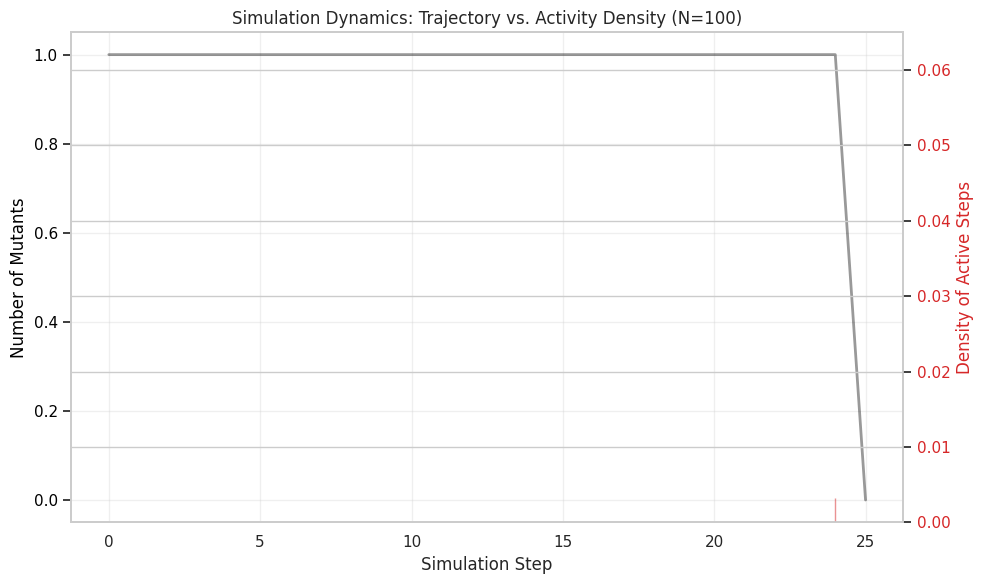

In [ ]:

# 3. Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Left Axis: The Simulation Trajectory ---
ax1.plot(steps, history, color='black', alpha=0.4, linewidth=2, label='Mutant Count')
ax1.set_xlabel('Simulation Step')
ax1.set_ylabel('Number of Mutants', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# --- Right Axis: The Density of Activity ---
ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
color = 'tab:red'

# KDE Plot: Smooths the density of the active_indices
sns.kdeplot(active_indices, ax=ax2, color=color, fill=True, alpha=0.3, bw_adjust=0.5, label='Activity Density')

# Rug Plot: Adds small ticks for every single active step
sns.rugplot(active_indices, ax=ax2, color=color, height=0.05, alpha=0.5)

ax2.set_ylabel('Density of Active Steps', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, None) # Ensure density starts at 0

plt.title(f'Simulation Dynamics: Trajectory vs. Activity Density (N={N})')
plt.tight_layout()
plt.show()

In [ ]:
result

{'fixation': False,
 'steps': 25,
 'initial_mutants': np.int64(1),
 'selection_coeff': 1.2,
 'duration': 0.0015755049998915638,
 'history': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0])}